# Ants and Markets Demonstration Notebook

## Notebook Structure

This Jupyter Notebook is structured into different sections, each serving a specific purpose. Here's a brief overview of each section:

**0. Git and environment setup**
- This section covers the setup of the Git repository and environment configuration required for the notebook.

**1. Imports and OS configuration**
- In this section, necessary libraries and modules are imported, and any specific configuration related to the operating system is done.

**2. Data Loading**
- This section enables to load COVID and stocks market data.

    **2.1 Merge and preprocess dataset**
    - Here, the loaded datasets are merged and preprocessed to prepare them for further analysis.

**3. Simulation Setup**
- This section involves setting up the simulation environment.

    **3.1 Hyperparameters Choice**
    - In this subsection, the appropriate hyperparameters for the simulation are selected.

    **3.2 Graphs Construction**
    - Here, the graphs used in subsequent analyses are constructed.

    **3.3 Model initialization**
    - The simulation model is initialized in this subsection.

**4. Calibration**
- This section covers the calibration process, where the model parameters are adjusted to fit the data.

**5. Batch Runs**
- This section focuses on conducting batch runs with varying size and graph types.

    **5.1 Batch run varying size**
    - Here, batch runs are performed with different sizes of agents.

    **5.2 Batch run varying graph**
    - Here, batch runs are performed with varying graph structures.

**6. Final model runs**
- FInally, the model is executed to generate results.

    **6.1 Single run**
    - In this subsection, the model is run once to obtain results for a specific scenario.

    **6.2 Multiple runs**
    - Multiple runs of the model are conducted to obtain confidence intervals.




### 0. Git and environment setup

In [ ]:
# first we need to clone the github repo if it was not cloned
# set cloned as true for the first time you run this notebook
cloned = True
if not cloned:
    ! git clone https://github.com/simonegiancola09/ants_markets.git .
venv = True
if not venv:
    # then make a new environment
    ! python3 -m venv local_python_environment



### Warning

If it is the first time the notebook is run, please, close it and open it again once the first cell is finished. Then, it is possible to set the variables above as ```False``` since the project is cloned and the environment was created. Please also choose as kernel ```local_python_environment```. 

In [4]:
# activate environment 
! source local_python_environment/bin/activate
# activate enviroment for jupyter notebooks
! ipython kernel install --user --name=local_python_environment 
# install requirements
try:
    ! pip3 install python-dateutil 
    ! pip3 install -r requirements.txt
    ! pip3 install --upgrade pandas
except:
    ! pip install python-dateutil 
    ! pip install -r requirements.txt
    ! pip install --upgrade pandas
# we found a bug on the system that might need users to call the last upgrade of pandas, but do not know why
# it is also flagged on StackOverflow
# if it does not work, please try to open and close again the notebook to allow for environment level changes
# to 'work'. That is our understanding of the matter

"source" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


Installed kernelspec local_python_environment in C:\Users\lisca\AppData\Roaming\jupyter\kernels\local_python_environment
  Using cached pandas-2.0.0-cp310-cp310-win_amd64.whl (11.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.1
    Uninstalling pandas-2.0.1:
      Successfully uninstalled pandas-2.0.1


ERROR: Could not install packages due to an OSError: [WinError 5] Accesso negato: 'C:\\Users\\lisca\\OneDrive\\Desktop\\bocconi\\master\\IIanno\\simulation\\project\\git\\ants_markets\\.venv\\Lib\\site-packages\\~-ndas\\_libs\\algos.cp310-win_amd64.pyd'
Check the permissions.



  Using cached pandas-2.0.1-cp310-cp310-win_amd64.whl (10.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.0
    Uninstalling pandas-2.0.0:
      Successfully uninstalled pandas-2.0.0


### 1. Imports and OS configuration

In [1]:
# main imports
import time
import numpy as np
import pandas as pd
# our coded functions imports
from src import global_configs, data_loading
from src.engineering import create_main_df, interaction_builder
from src.visuals import basic_views, make_gif
from src.modeling import agents_construction, calibration
from src.utils import utils
# initialization of Global Variables
global_configs.init()

In [2]:
# here we can attempt to use a function written in another script as below
############## GREETINGS ########################################################
print('Starting main.py file. Welcome to the pipeline for our project...')
print('Today we will try to run our model, you are free to choose parameters in the main.py file')
print('WARNING: if you encounter issues due to missing modules, there is a requirements.txt file ready for you.')
print('In this case, please run on your terminal pip install requirements.txt or what you prefer in your envinroment of choice')
print("Creating the necessary folders...")
# if windows OS maybe the first option is better
windows = False
if windows:
    utils.create_directory('reports')
    utils.create_directory('reports/figures')
    utils.create_directory('reports/outputs')
    utils.create_directory('reports/figures/nest_dynamics')

else:
    utils.create_directory('./reports')
    utils.create_directory('./reports/figures')
    utils.create_directory('./reports/outputs')
    utils.create_directory('./reports/figures/nest_dynamics')


Starting main.py file. Welcome to the pipeline for our project...
Today we will try to run our model, you are free to choose parameters in the main.py file
In this case, please run on your terminal pip install requirements.txt or what you prefer in your envinroment of choice
Creating the necessary folders...


### 2. Data Loading

In [3]:

# Please choose here the stock and the dates for calibration 
stock_name = 'NVDA'                     # name of stock
dates = ('2019-01-01', '2020-06-30')    # dates for stock data, must be larger than what we
                                        # use for covid to calibrate
print('Your stock of choice is {} in the historical dates {}'.format(stock_name, dates))

Your stock of choice is NVDA in the historical dates ('2019-01-01', '2020-06-30')


In [4]:
############## DATA LOADING ###########################################
# run only once, then set as True
loaded = True                          
# if data is not loaded, we load it here
if not loaded:
    print('Loading data...')
    load_time_start = time.time()
    # load total number of cases
    data_loading.load_covid_data()
    # load stock name under specific dates
    data_loading.load_financial_data(stock_name=stock_name, dates=dates)
    # create series of R number data
    create_main_df.load_R_number_data()
    # create dataset with R number and cases for simplicity
    create_main_df.retrieve_cases_and_R_number()
    load_time_end = time.time()
    load_time = load_time_end - load_time_start
    print('Finished downloading datasets in {} seconds'.format(np.round(load_time, 2)))
################################################################################################################

############## Stocks data ###############################
print('Retrieving stock data...')
df_stocks = pd.read_csv('data/raw/financial_US_{}_raw.csv'.format(stock_name))
##########################################################

############## Covid Data ###############################
print('Retrieving Covid-19 data...')
# this dataset has more information than just the Rt
df_covid = pd.read_csv('data/engineered/df_covid.csv')

df_covid.columns = ['date', 'cases', 'Rt', 'R_var']



Retrieving stock data...
Retrieving Covid-19 data...


#### 2.1 Merge and preprocess dataset

In [5]:
############# Merge Datasets ############################
df = pd.merge(df_stocks, df_covid, left_on='Date', right_on='date', how='left')
# proprocess data to obtain the "temperature" values
df.head()
df = utils.preprocess_data(df) 
##########################################################

### 3. Simulation Setup

In [6]:
##### QUICK ATTEMPT VS HEAVY SIMULATION ##################
# to let users try the model we will report here two combinations
# of parameters that highly influence the duration of the script
# once one chooses the parameter below it will interpolate
# between two main configs
short_sim = 1          # if 1 very short simulation
if short_sim:
    print('Today we will just check that everything works as expected.')
    print('Do not trust these small size results')
else:
    print('Today we will run a heavy simulation')
    print('it might take a lot of time if your PC is not powerful')


Today we will just check that everything works as expected.
Do not trust these small size results


#### 3.1 Hyperparameters Choice

Here we enable useres to freely choose the parameters of the model:


In [7]:
############## HYPERPARAMETERS ###############################
print('Setting hyperparameters...')
# here we store some parameters of choice
#### General hypeparams ############
T = 'change_daily'                             # "Temperature" parameter
N = 100 * short_sim + 500 * (1 - short_sim)    # num of nodes
M = 10                                      # num of edges per node for cluster
P = 0.5                                     # p of connection for erdos renyi and cluster graph
debug=False                                 # set to True to visualize supply/demand curves every 5 steps
##########
#### Ant-Like hypeparams ############
alpha = -0.69                       # parameter controlling how much the temperature contributes
##########
#### DemandSupply-Like hypeparams ############
k = 0.105                           # parameter controlling impact of neighbors' past orders on price proposal        
prob_type = [1., 0.0, 0.0, 0.0]     # distribution over types of traders
p_f = None                          # price value for fundamentalist traders 
                                    # (set to None to automatically give mean price of price history)
cash_low = 50000                    # paramenters on distribution of wealth
cash_high = 200000
stocks_low = 1000
stocks_high = 5000
#########################

Setting hyperparameters...


#### 3.2 Graphs Construction

In [8]:
############### GRAPHS CONSTRUCTION #####################
# below are different types of Rt to test our dynamics
print('Building graphs...')
# below are different types of interaction graphs to test our dynamics
# choice for the weights distribution
weights_distribution = np.random.uniform(0.8,1.2)

G_1 = interaction_builder.graph_generator(type = 'Erdos-Renyi',
                    weights_distribution = lambda : weights_distribution,
                    **{'n':N, 'p':P})
G_2 = interaction_builder.graph_generator(type = 'Clique', 
                    weights_distribution = lambda : weights_distribution,
                    **{'n' : N})
G_3 = interaction_builder.graph_generator(type = 'Null',
                    weights_distribution = lambda : weights_distribution,
                    **{'n' : N})
G_4 = interaction_builder.graph_generator(type = 'Powerlaw-Cluster',
                    weights_distribution = lambda : weights_distribution, 
                    **{'n' : N, 'm' : M, 'p' : P})

##################################################################

Building graphs...


#### 3.3 Model initialization

In [9]:
################ SPECIFIC CHOICES FOR MODEL INITIALIZATION ########################
G = G_4                             # graph chosen
start = 2                           # simulation begins 'start' days before pandemic
start_pre = 30                      # simulation before covid
epochs = df['start'].max() + start  # number of iterations  
epochs_pre = df['start'].max() + start_pre    
price = df.loc[df['start'] <= -start, 'Close']
Rt = df.loc[df['start'] > -start, T].values

fixed_kwargs = {
            'k':k, 
            'interaction_graph' : G,
            'prob_type':prob_type,
            'alpha' : alpha,
            'p_f' : p_f,
            'cash_low' : cash_low,
            'cash_high' : cash_high,
            'stocks_low' : stocks_low,
            'stocks_high' : stocks_high,
            'debug':debug
            }
##########################################################

################ MODEL INITIALIZATION #######################################################
print('Building the first model...')
model = utils.build_model(df, start, fixed_kwargs, T)
model_pre = utils.build_model(df, start_pre, fixed_kwargs, T)

Building the first model...


### 4. Calibration

In [ ]:

############# CALIBRATION ##################################
print('Calibration of Pandemic contribution...')
calibration_time_start = time.time()

std = 0.2                                                   # std of normal proposal
param_start = -0.5                                          # initial guess for the parameter
iterations_mh = 3 * short_sim + 500 * (1 - short_sim)       # number of iterations
internal_iterations = 5
true_data = df.loc[df['start'] > -start, 'Close']
burn_in = 0                                                 # number of burn in iterations
multi=False
fit_alpha=True
loss = calibration.compute_log_likelihood
preprocess = True

calibration_output = calibration.metropolis_hastings(
    model, 
    iterations_mh, 
    internal_iterations,
    loss,
    preprocess,
    param_start, 
    std, 
    true_data, 
    burn_in, 
    multi=multi,
    fit_alpha=fit_alpha)
if windows:
    utils.save_dictionary_to_file(calibration_output, 'reports/outputs/MH_output.txt')
else:
    utils.save_dictionary_to_file(calibration_output, 'reports/outputs/MH_output.txt')

calibration_time_end = time.time()
calibration_time = calibration_time_end - calibration_time_start
basic_views.plot_chain(calibration_output, save=True, save_name='MH_chain', title='Metropolis Hastings chain')

print('Calibration finished in {} seconds'.format(np.round(calibration_time, 2)))


### UPDATE ALPHA ACCORDING TO THE VALUE FOUND IN CALIBRATION ####
alpha = calibration_output['parameter estimate']

### 5. Batch Runs

#### 5.1 Batch run varying size

In [14]:

################ BATCH RUN (VARYING N) #######################################################

print('Starting batch run varying N (number of agents)...')
start_time_varying_N = time.time()
iterations_batch = 2 * short_sim + 4 * (1 - short_sim)
save = True
save_name = 'batch_run_graph'
t1 = time.time()
test_N = True                   # may take a lot of time
all_graphs = []
if not short_sim:
    # attention, very long!!!!!!!!
    n_list = [50, 100, 250, 500, 750, 1000, 1500, 2000, 3000, 5000]
else:
    n_list = [100, 250]
for n in n_list: 
    M = 10
    P = 0.5
    Graph = interaction_builder.graph_generator(type = 'Powerlaw-Cluster',
                weights_distribution = lambda : weights_distribution, 
                                    **{'n' : n, 'm' : M, 'p' : P})
    all_graphs.append(Graph)

fixed_params = {
    'k' : k, 
    'price_history' : list(price),
    'external_var': Rt,
    'prob_type':prob_type,
    'alpha' : alpha,
    'p_f' : p_f,
    'cash_low' : cash_low,
    'cash_high' : cash_high,
    'stocks_low' : stocks_low,
    'stocks_high' : stocks_high,
    'debug':False
}

variable_params = {
    'interaction_graph' : all_graphs
}

reporters = {'price' : calibration.extract_price}

df_batch_N = calibration.batch_run(
    agents_construction.Nest_Model, variable_params, fixed_params, reporters, 
    epochs, iterations=iterations_batch)

t2 = time.time()

df_N = utils.group_batch(df_batch_N, 'N', 'price')

basic_views.plot_aggregate(df, df_N, start, 'N', save=True, save_name='batch_run_N',
title='Stock price simulation - varying size', show=True)
end_time_varying_N = time.time()
tot_time_varying_N = end_time_varying_N - start_time_varying_N
print('Varying number of investors run finished in {} seconds'.format(np.round(tot_time_varying_N, 2)))

##########################################################

Starting batch run varying N (number of agents)...


4it [02:56, 44.10s/it]


TypeError: plot_aggregate() got an unexpected keyword argument 'show'

#### 5.2 Batch run varying graph

In [ ]:

################ BATCH RUN (VARYING GRAPH) #######################################################
print('Starting batch run varying graph type...')
start_time_varying_graph = time.time()
iterations_batch = 2 * short_sim + 10 * (1 - short_sim) 

G_1 = interaction_builder.graph_generator(type = 'Erdos-Renyi',
                    weights_distribution = lambda : weights_distribution,
                    **{'n':N, 'p':P})
G_2 = interaction_builder.graph_generator(type = 'Clique', 
                    weights_distribution = lambda : weights_distribution,
                    **{'n' : N})
G_3 = interaction_builder.graph_generator(type = 'Null',
                    weights_distribution = lambda : weights_distribution,
                    **{'n' : N})
G_4 = interaction_builder.graph_generator(type = 'Powerlaw-Cluster',
                    weights_distribution = lambda : weights_distribution, 
                                        **{'n' : N, 'm' : M, 'p' : P})
graphs = ['Null', 'Clique', 'Erdos-Renyi', 'Powerlaw-Cluster']
all_graphs = [G_3, G_2, G_1, G_4]

variable_params = {
    'interaction_graph' : all_graphs
}

df_batch_graph = calibration.batch_run(
    agents_construction.Nest_Model, variable_params, fixed_params, reporters, 
    epochs, iterations=iterations_batch)

df_batch_graph['graph_type'] = [g for g in graphs for _ in range(iterations_batch)]

df_graph = utils.group_batch(df_batch_graph, 'graph_type', 'price')

basic_views.plot_aggregate(df, df_graph, start, 'graph_type', save=True, 
                        save_name='batch_run_graph', title='Stock price simulation - varying graph', show=True)
end_time_varying_graph = time.time()
tot_time_varying_graph = end_time_varying_graph - start_time_varying_graph
print('Multi Run ABM finished in {} seconds'.format(np.round(tot_time_varying_graph, 2)))
######################################################################






### 6. Final model runs

#### 6.1 Single run

Running ABM...
Run ABM finished in 24.85 seconds
Creating Plots...


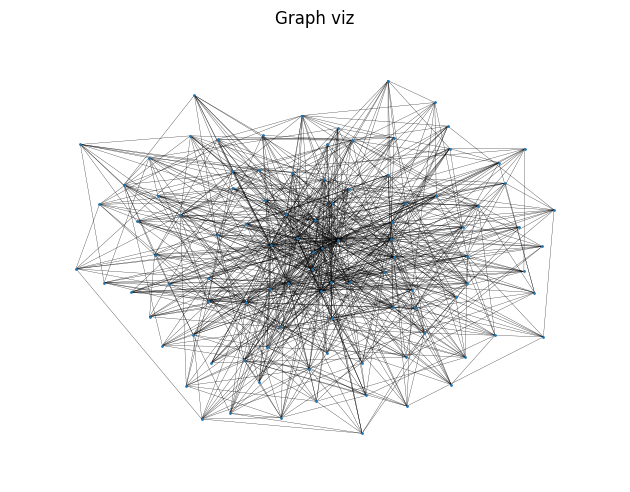

Making a GIF might take a lot of time...
Plots finished in 98.22 seconds


In [10]:

################ MODEL SINGLE RUN (COVID ONLY) #######################################################
print('Running ABM...')
model_time_start = time.time()     
model = utils.build_model(df, start, fixed_kwargs, T)
df_model, df_agents = agents_construction.run_model(model=model, epochs=epochs)
model_time_end = time.time()
model_time = model_time_end - model_time_start
print('Run ABM finished in {} seconds'.format(np.round(model_time, 2)))
#######################################################
################ PLOTS #######################################################
time.sleep(3)

print('Creating Plots...')
plots_time_start = time.time()

basic_views.plot_graph(G, save = True, title = 'Graph viz', show=True)
basic_views.plot_simulation(df, df_model, start, pct=False, save=True, save_name='Single_run_post')
basic_views.plot_macro_dynamics(df_model, save = True, save_name='first_attempt')
basic_views.plot_agents_dynamics(df_model, df_agents, title = 'Nest_all_steps', 
                                         hue = 'buy_sell', save = True)

print('Making a GIF might take a lot of time...')
make_gif.GIF_creator(directory_source = 'reports/figures/nest_dynamics/', 
                     filename = 'Nest_all_steps', 
                     directory_destination = 'reports/figures/',
                     duration=50)
plots_time_end = time.time()
plots_time = plots_time_end - plots_time_start
print('Plots finished in {} seconds'.format(np.round(plots_time, 2)))

##########################################################

#### 6.2 Multiple runs

We first do a multi run concerning the COVID period only.

Starting ABM multiple runs (Covid period only)...


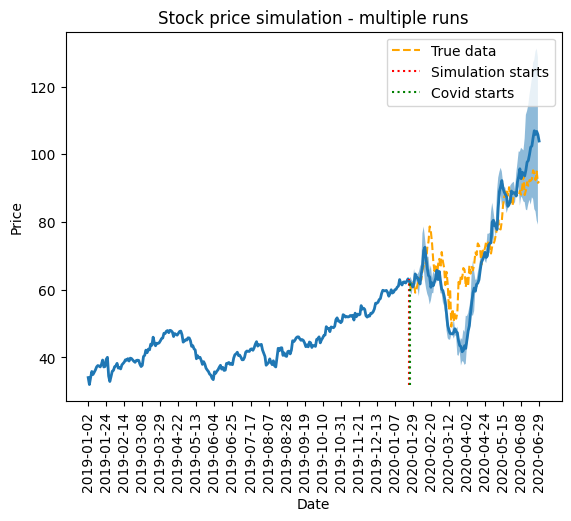

Multi Run ABM finished in 49.42 seconds


In [11]:
##########################################################
################ MODEL MULTI RUN (COVID ONLY) #######################################################
print('Starting ABM multiple runs (Covid period only)...')

iterations_multirun = 2 * short_sim + 10 * (1 - short_sim)
model_time_start = time.time()   
model = utils.build_model(df, start, fixed_kwargs, T)
results_post_covid = calibration.multi_run(model=model, epochs=epochs, iterations=iterations_multirun)
model_time_end = time.time()
basic_views.plot_multi_run(df, 
                           results_post_covid['prices'], 
                           start, save=True, 
                           save_name='Multi_run_post_covid',
                            title='Stock price simulation - multiple runs', show=True
                            )
model_time = model_time_end - model_time_start
print('Multi Run ABM finished in {} seconds'.format(np.round(model_time, 2)))

##########################################################

Then we try to test how our model behaves with no external shocks.

Starting ABM multiple runs...


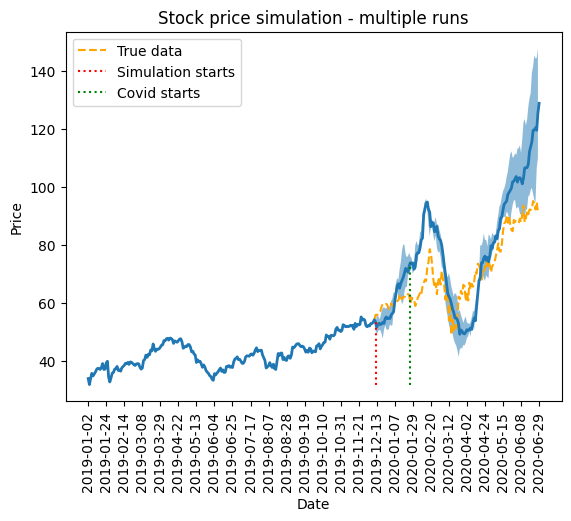

Multi Run ABM finished in 62.43 seconds


In [12]:
################ MODEL MULTI RUN (BEFORE COVID) #######################################################
print('Starting ABM multiple runs...')

model_time_start = time.time()          
results_pre_covid = calibration.multi_run(model=model_pre, epochs=epochs_pre, iterations=iterations_multirun)
model_time_end = time.time()
basic_views.plot_multi_run(df, 
                            results_pre_covid['prices'], 
                            start_pre, save=True, 
                            save_name='Multi_run_pre_covid',
                            title='Stock price simulation - multiple runs', show=True
                            )
model_time = model_time_end - model_time_start
print('Multi Run ABM finished in {} seconds'.format(np.round(model_time, 2)))

##########################################################